# Title of Project

## Part 1. Data Loading & Preprocessing

### Environment Set-up & Verification

In [2]:
import importlib
import sys

packages = [
    "python",
    "numpy",
    "scipy",
    "pandas",
    "matplotlib",
    "sklearn",
    "hyperspy",
    "ipywidgets",
    "seaborn",
    "tqdm"
]

print("Environment check")
print("=" * 50)
print(f"Python executable: {sys.executable}")
print(f"Python version: {sys.version.split()[0]}")
print("=" * 50)

for pkg in packages: 
    try:
        if pkg == "python":
            continue
        module = importlib.import_module(pkg)
        version = getattr(module, "__version__", "No__version__attribute")
        print(f"{pkg:15s} : {version}")
    except ImportError:
        print(f"{pkg:15s} : NOT INSTALLED")

# HyperSpy is the primary library for this project. Please explicitly confirm it's loading.

import hyperspy.api as hs
print("\nHyperSpy API successfully imported.")

Environment check
Python executable: C:\Users\elise\miniforge3\envs\zincsoap-ml\python.exe
Python version: 3.10.19
numpy           : 1.26.4
scipy           : 1.15.2
pandas          : 2.3.3
matplotlib      : 3.10.8
sklearn         : 1.7.2
hyperspy        : 2.4.0
ipywidgets      : 8.1.8
seaborn         : 0.13.2
tqdm            : 4.67.3

HyperSpy API successfully imported.


### Imports & project paths

In [3]:
from pathlib import Path
import os, gzip, shutil
import numpy as np
import matplotlib.pyplot as plt
import hyperspy.api as hs

DATA = Path(r"./data_raw")
OUT = Path(r"./data_processed")
FIGS = Path(r"./figures")
OUT.mkdir(exist_ok=True)
FIGS.mkdir(exist_ok=True)

print("DATA:", DATA.resolve())
print("OUT:", OUT.resolve())
print("FIGS:", FIGS.resolve())

DATA: C:\Users\elise\OneDrive\Desktop\ZINCSOAP\data_raw
OUT: C:\Users\elise\OneDrive\Desktop\ZINCSOAP\data_processed
FIGS: C:\Users\elise\OneDrive\Desktop\ZINCSOAP\figures


## Extract .raw from .raw.gz

In [4]:
def gunzip_if_needed(gz_path: Path) -> Path: 
    raw_path = gz_path.with_suffix("")
    if raw_path.exists():
        print(f"[skip] {raw_path.name} already exists")
        return raw_path

    print(f"[do] Extracting {gz_path.name} -> {raw_path.name}")
    with gzip.open(gz_path, "rb") as f_in, open(raw_path, "wb") as f_out:
        shutil.copyfileobj(f_in, f_out)

    return raw_path

aerial_gz = DATA / "Aerial 150x.raw.gz"
cs_gz = DATA / "CS 148x.raw.gz"

aerial_raw = gunzip_if_needed(aerial_gz)
cs_raw = gunzip_if_needed(cs_gz)

print("Done extracting.")

[skip] Aerial 150x.raw already exists
[skip] CS 148x.raw already exists
Done extracting.


### Load Aerial dataset & crop empty rows

In [5]:
aerial_rpl = DATA / "Aerial 150x.rpl"

sA = hs.load(aerial_rpl).inav[:, :600] # Crop, bottom pixels empty
sA.set_signal_type("EDS_SEM")
print(type(sA))
print(sA)

C:\Users\elise\miniforge3\envs\zincsoap-ml\lib\site-packages\hyperspy\misc\_utils.py:1590: VisibleDeprecationWarning: Importing `LazyComplexSignal1D` from `hyperspy._signals.complex_signal1d` is deprecated and will be removed in the HyperSpy 3.0 release. Import it from `hyperspy.signals` instead.
  warnings.warn(
C:\Users\elise\miniforge3\envs\zincsoap-ml\lib\site-packages\hyperspy\misc\_utils.py:1590: VisibleDeprecationWarning: Importing `LazySignal1D` from `hyperspy._signals.signal1d` is deprecated and will be removed in the HyperSpy 3.0 release. Import it from `hyperspy.signals` instead.
  warnings.warn(


<class 'exspy.signals.eds_sem.EDSSEMSpectrum'>
<EDSSEMSpectrum, title: , dimensions: (1024, 600|3093)>


### Set axes & EDS metadata
*Note: this is lifted directly from the authors' approach. It is possible to re-derive scales from the metadata, but this serves as a start.

In [6]:
# Spatial calibration
sA.axes_manager[0].name = "x"
sA.axes_manager[0].scale = 0.8451
sA.axes_manager[0].units = "µm"

sA.axes_manager[1].name = "y"
sA.axes_manager[1].scale = 0.8451
sA.axes_manager[1].units = "µm"

# Energy Calibration
sA.axes_manager[2].name = "Energy"
sA.axes_manager[2].offset = -0.955
sA.axes_manager[2].scale = 0.01
sA.axes_manager[2].units = "keV"

# EDS elements
sA.add_elements(["C","Cl","Zn","O","Cd","S"])

sA.metadata.General.title = "Aerial EDS Spectrum Image"

sA.axes_manager

Navigation axis name,size,index,offset,scale,units
x,1024,0,0.0,0.8451,µm
y,600,0,0.0,0.8451,µm
Signal axis name,size,,offset,scale,units
Energy,3093,,-0.955,0.01,keV


### Save to .hspy for faster reload

In [7]:
aerial_hspy = OUT / "Aerial 150x.hspy"
sA.save(aerial_hspy, overwrite=True)
print("Saved:", aerial_hspy)

Saved: data_processed\Aerial 150x.hspy


### Repeat for Cross-section

In [8]:
cs_rpl = DATA / "CS 148x.rpl"

sC = hs.load(cs_rpl).inav[:, 115:] # Crop, bottom pixels are empty
sC.set_signal_type("EDS_SEM")
print(type(sC))
print(sC)

<class 'exspy.signals.eds_sem.EDSSEMSpectrum'>
<EDSSEMSpectrum, title: , dimensions: (1024, 653|3144)>


In [9]:
# Spatial calibration
sC.axes_manager[0].name = "x"
sC.axes_manager[0].scale = 0.859
sC.axes_manager[0].units = "µm"

sC.axes_manager[1].name = "y"
sC.axes_manager[1].scale = 0.8859
sC.axes_manager[1].units = "µm"

# Energy Calibration
sC.axes_manager[2].name = "Energy"
sC.axes_manager[2].offset = -0.955
sC.axes_manager[2].scale = 0.01
sC.axes_manager[2].units = "keV"

# EDS signal type + elements
sC.set_signal_type("EDS_SEM")
sC.add_elements(["C","Cl","Zn","O","Cd","S"])

sC.metadata.General.title = "Cross-section EDS Spectrum Image"

cs_hspy = OUT / "CS 148x.hspy"
sC.save(cs_hspy, overwrite=True)
print("Saved:", cs_hspy)

Saved: data_processed\CS 148x.hspy


### Preliminary Inspection

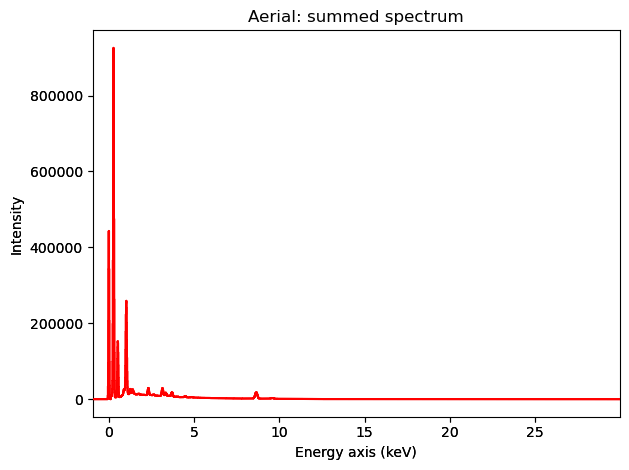

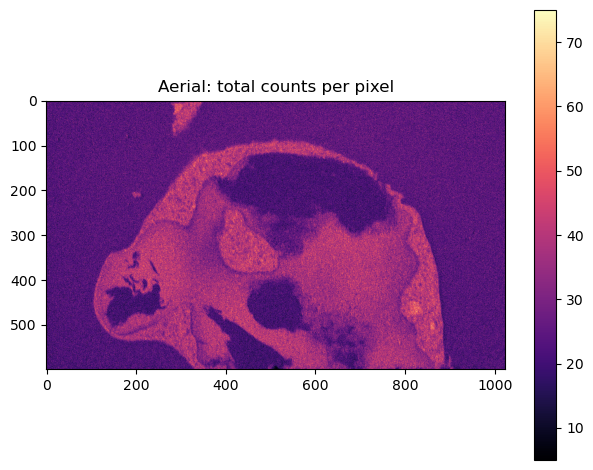

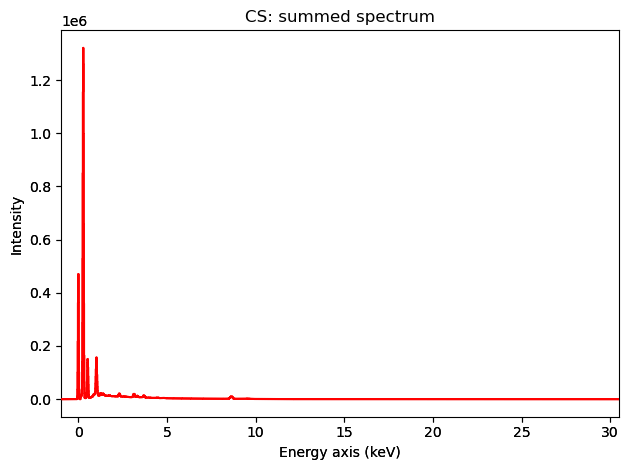

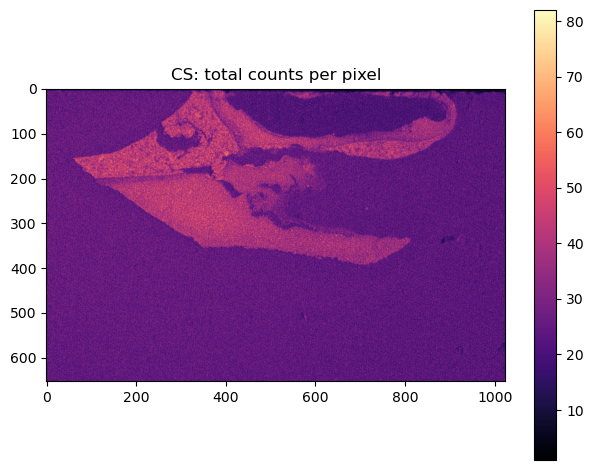

In [10]:
def quick_inspect(s, label):
    # Summed spectrum
    sum_spec = s.sum(axis=(0, 1))
    sum_spec.plot()
    plt.title(f"{label}: summed spectrum")
    plt.show()

    # Total counts per pixel (sum over energy)
    total_counts = s.sum(axis=2)
    plt.figure()
    plt.imshow(total_counts.data, cmap="magma")
    plt.title(f"{label}: total counts per pixel")
    plt.colorbar()
    plt.tight_layout()
    plt.savefig(FIGS / f"{label}_total_counts.png", dpi=300)
    plt.show()

quick_inspect(sA, "Aerial")
quick_inspect(sC, "CS")

### Simple preliminary preprocessing + one integrated elemental map (authors' Cl example)

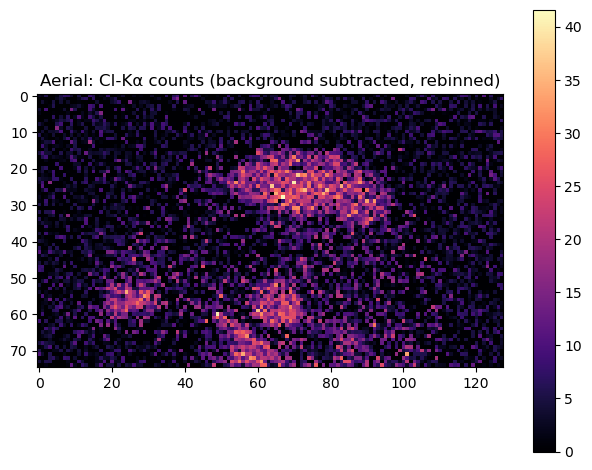

cl_ka shape: (75, 128)


In [11]:
# Authors' Cl background windows in keV
bkg_win_cl = np.array([
    [2.52, 2.56, 2.85, 2.92], # Cl_Ka background windows
    [2.52, 2.56, 2.85, 2.92], # Cl_Kb background windows
])

# Load the saved aerial.hspy and rebin like the authors
s = hs.load(aerial_hspy).isig[:-1].rebin(scale=(8,8,2))

cl_ka, cl_kb = s.get_lines_intensity(
    xray_lines=["Cl_Ka", "Cl_Kb"],
    background_windows=bkg_win_cl,
    plot_result=False
)

# Clean negative counts for display
cl_ka.data[cl_ka.data < 0] = 0

# Plot and save
plt.figure()
plt.imshow(cl_ka.data, cmap="magma")
plt.title("Aerial: Cl-Kα counts (background subtracted, rebinned)")
plt.colorbar()
plt.tight_layout()
plt.savefig(FIGS / "Aerial_Cl-Kalpha_counts.png", dpi=300)
plt.show()

print("cl_ka shape:", cl_ka.data.shape)

## Part 2. Feature Construction (preliminary)

### Imports + paths + plotting defaults

In [12]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import hyperspy.api as hs
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Folders
OUT = Path ("./data_processed")
FIGS = Path ("./figures")
OUT.mkdir(exist_ok=True)
FIGS.mkdir(exist_ok=True)

# Plot defaults
DEFAULT_CMAP = "magma"
plt.rcParams["figure.dpi"] = 120

print("Ready.")

Ready.


In [13]:
# Element / line list based on the dataset authors' workflow.
# NOTE (future me): revisit element/line choice later by validating peaks in summed spectra
# and checking whether any elements are dominated by noise or contamination.
XRAY_LINES = ["C_Ka", "O_Ka", "Cl_Ka", "S_Ka", "Zn_Ka", "Cd_La"]

XRAY_LINES

['C_Ka', 'O_Ka', 'Cl_Ka', 'S_Ka', 'Zn_Ka', 'Cd_La']

### Confirm signals are EDS and have elements registered

In [14]:
def ensure_eds_sem(s, elements=("C","O","Cl","S","Zn","Cd")):
    s.set_signal_type("EDS_SEM")
    s.add_elements(list(elements))
    return s

sA = ensure_eds_sem(sA)
sC = ensure_eds_sem(sC)

print(type(sA))
print(type(sC))

<class 'exspy.signals.eds_sem.EDSSEMSpectrum'>
<class 'exspy.signals.eds_sem.EDSSEMSpectrum'>


### Trouble shooting

In [15]:
# Diagnostics for cell ^ issues
REBIN_SCALE = (8, 8, 2)  # (nav0_factor, nav1_factor, signal_factor)

# Ensure lazy
sC = sC.as_lazy()

# --- Diagnose axis sizes ---
nav_shape = sC.axes_manager.navigation_shape
sig_shape = sC.axes_manager.signal_shape

print("Navigation shape:", nav_shape)  # (nav0, nav1)
print("Signal shape    :", sig_shape)  # (energy_channels,)

f0, f1, fe = REBIN_SCALE
n0, n1 = nav_shape
ne = sig_shape[0]

print("Nav0 mod f0:", n0 % f0)
print("Nav1 mod f1:", n1 % f1)
print("Sig  mod fe:", ne % fe)

# --- Compute trimmed sizes (largest divisible <= original) ---
n0_trim = n0 - (n0 % f0)
n1_trim = n1 - (n1 % f1)
ne_trim = ne - (ne % fe)

print("Trimming to nav:", (n0_trim, n1_trim), "signal:", ne_trim)

# --- Apply trimming (trim only the end of each axis) ---
sC_trim = sC.inav[:n0_trim, :n1_trim].isig[:ne_trim]

# --- Now rebin should work lazily ---
sC_rb = sC_trim.rebin(scale=REBIN_SCALE)

print("Rebinned CS:", sC_rb)
print("Rebinned nav shape:", sC_rb.axes_manager.navigation_shape)
print("Rebinned signal shape:", sC_rb.axes_manager.signal_shape)

Navigation shape: (1024, 653)
Signal shape    : (3144,)
Nav0 mod f0: 0
Nav1 mod f1: 5
Sig  mod fe: 0
Trimming to nav: (1024, 648) signal: 3144
Rebinned CS: <LazyEDSSEMSpectrum, title: Cross-section EDS Spectrum Image, dimensions: (128, 81|1572)>
Rebinned nav shape: (128, 81)
Rebinned signal shape: (1572,)


In [16]:
sA = sA.as_lazy()
nav = sA.axes_manager.navigation_shape
sig = sA.axes_manager.signal_shape
f0, f1, fe = REBIN_SCALE

n0, n1 = nav
ne = sig[0]

sA_trim = sA.inav[:n0 - (n0 % f0), :n1 - (n1 % f1)].isig[:ne - (ne % fe)]
sA_rb = sA_trim.rebin(scale=REBIN_SCALE)

print("Rebinned Aerial:", sA_rb)

Rebinned Aerial: <LazyEDSSEMSpectrum, title: Aerial EDS Spectrum Image, dimensions: (128, 75|1546)>


In [17]:
# Extract line-intensity maps for both datasets
XRAY_LINES = ["C_Ka", "O_Ka", "Cl_Ka", "S_Ka", "Zn_Ka", "Cd_La"]

mapsA = sA_rb.get_lines_intensity(xray_lines=XRAY_LINES, plot_result=False)
mapsC = sC_rb.get_lines_intensity(xray_lines=XRAY_LINES, plot_result=False)

print("Aerial map shape:", mapsA[0].data.shape)
print("CS map shape    :", mapsC[0].data.shape)
print("Lines:", XRAY_LINES)

Aerial map shape: (75, 128)
CS map shape    : (81, 128)
Lines: ['C_Ka', 'O_Ka', 'Cl_Ka', 'S_Ka', 'Zn_Ka', 'Cd_La']


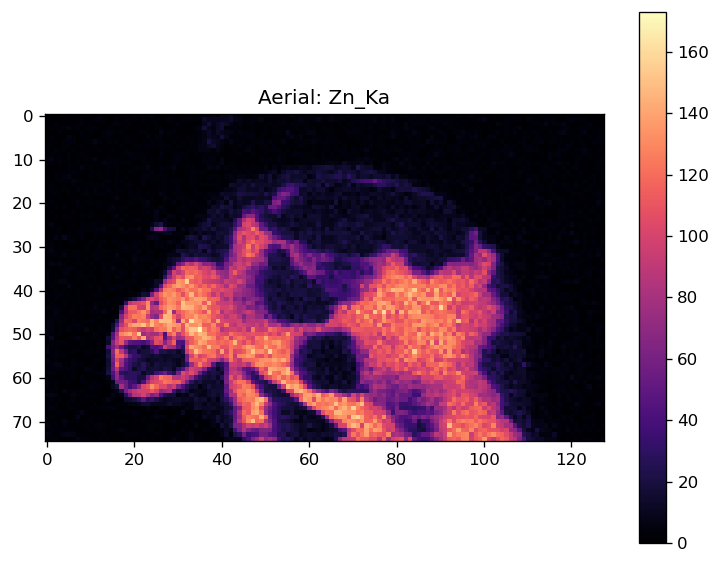

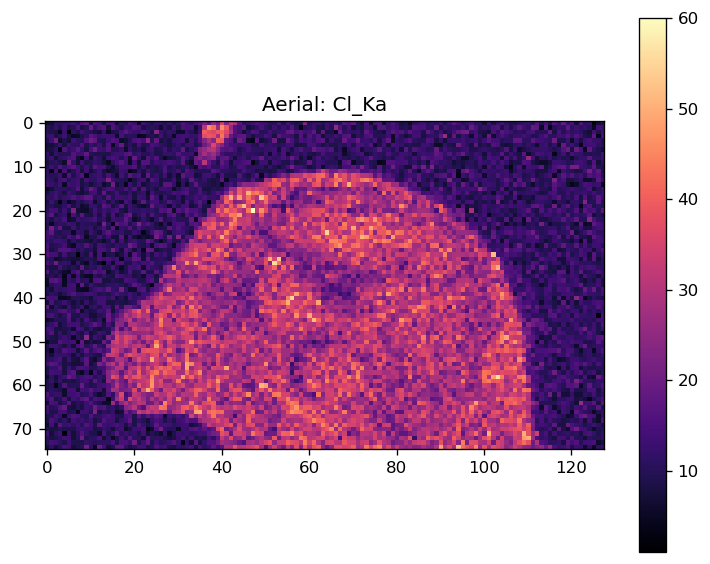

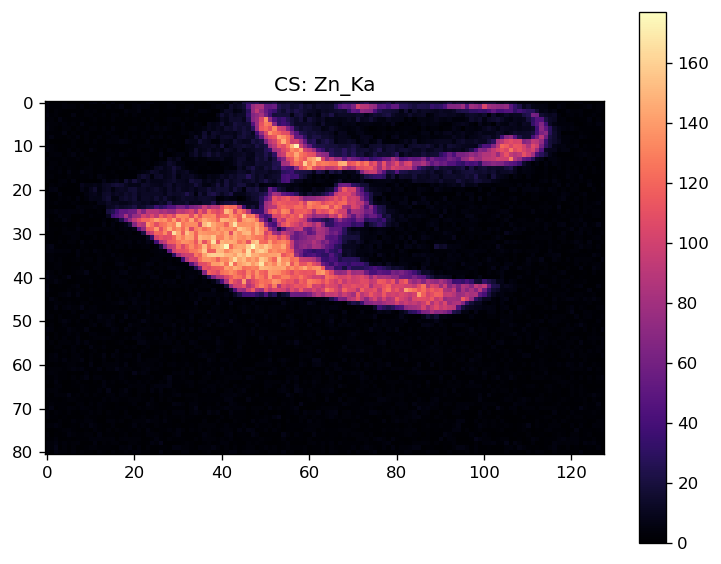

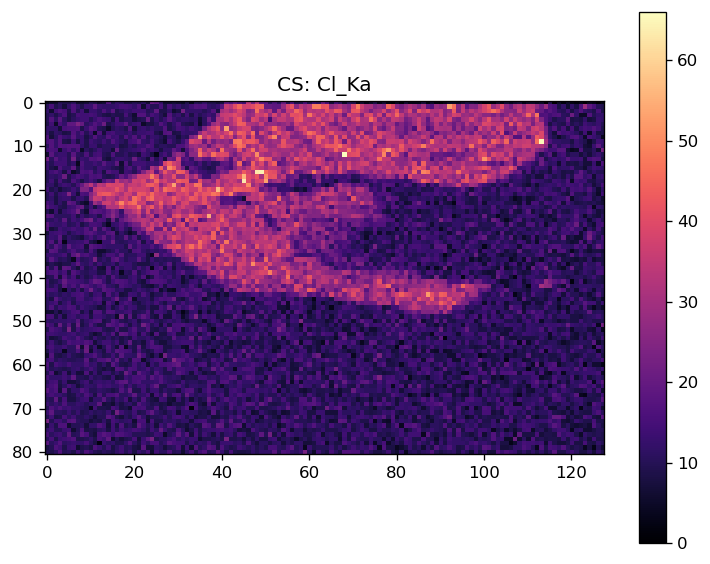

In [18]:
# Quick visual sanity check (Zn + Cl)
import numpy as np
import matplotlib.pyplot as plt

def show_line_map(m, title, cmap="magma"):
    img = np.asarray(m.data)
    img = img.copy()
    img[img < 0] = 0
    plt.figure()
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

show_line_map(mapsA[4], "Aerial: Zn_Ka")  # Zn is index 4 in XRAY_LINES
show_line_map(mapsA[2], "Aerial: Cl_Ka")  # Cl is index 2

show_line_map(mapsC[4], "CS: Zn_Ka")
show_line_map(mapsC[2], "CS: Cl_Ka")

In [19]:
# Build feature matrices
def maps_to_X(maps, dtype=np.float32):
    cols = [np.asarray(m.data, dtype=dtype).ravel() for m in maps]
    return np.column_stack(cols)

XA = maps_to_X(mapsA)
XC = maps_to_X(mapsC)

print("XA:", XA.shape, XA.dtype)
print("XC:", XC.shape, XC.dtype)

XA: (9600, 6) float32
XC: (10368, 6) float32


In [20]:
# Mask low-signal pixels
def low_signal_mask(X, quantile=0.05):
    strength = X.sum(axis=1)
    thresh = np.quantile(strength, quantile)
    keep = strength > thresh
    return keep, thresh

keepA, thrA = low_signal_mask(XA, 0.05)
keepC, thrC = low_signal_mask(XC, 0.05)

XA_k = XA[keepA]
XC_k = XC[keepC]

print("Aerial kept:", keepA.mean(), "threshold:", thrA)
print("CS kept    :", keepC.mean(), "threshold:", thrC)

Aerial kept: 0.9486458333333333 threshold: 535.0
CS kept    : 0.9497492283950617 threshold: 599.0


In [21]:
# PCA + KMeans (starting w/ k=4)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def pca_kmeans(X_keep, k=4, n_pca=6, random_state=0):
    scaler = StandardScaler()
    Z = scaler.fit_transform(X_keep)

    pca = PCA(n_components=n_pca, random_state=random_state)
    P = pca.fit_transform(Z)

    km = KMeans(n_clusters=k, random_state=random_state, n_init="auto")
    labels = km.fit_predict(Z)

    sil = silhouette_score(Z, labels) if k > 1 else np.nan
    return scaler, pca, km, labels, sil

k = 4
scA, pA, kmA, labA, silA = pca_kmeans(XA_k, k=k)
scC, pC, kmC, labC, silC = pca_kmeans(XC_k, k=k)

print("Aerial silhouette:", silA)
print("CS silhouette    :", silC)
print("Aerial PCA EVR   :", pA.explained_variance_ratio_)
print("CS PCA EVR       :", pC.explained_variance_ratio_)

C:\Users\elise\miniforge3\envs\zincsoap-ml\lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Aerial silhouette: 0.5531752109527588
CS silhouette    : 0.6057707071304321
Aerial PCA EVR   : [0.57836175 0.25564253 0.11188995 0.03650028 0.01398925 0.00361632]
CS PCA EVR       : [0.6358287  0.21087609 0.10168094 0.03556113 0.01288902 0.00316414]


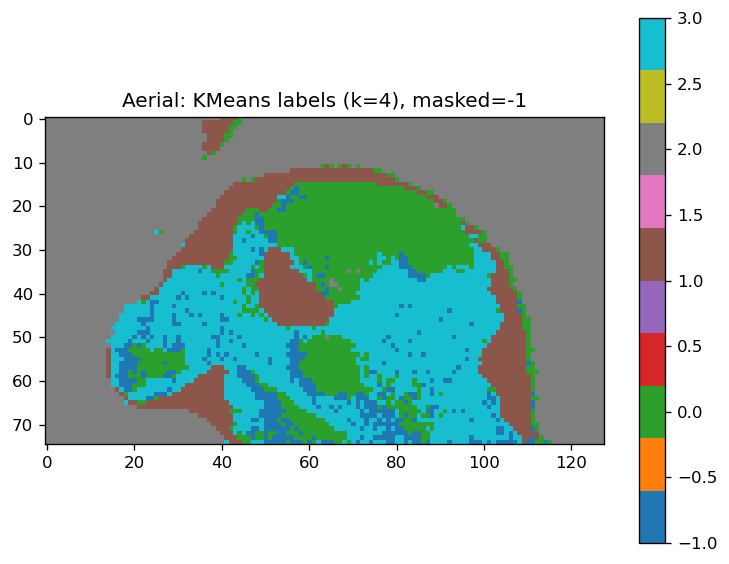

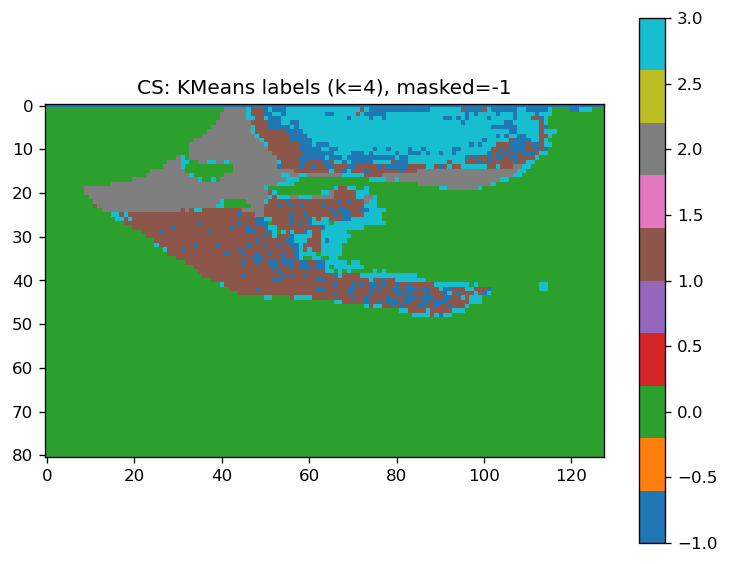

In [22]:
# Pull labels back into spatial maps
def labels_to_map(labels_keep, keep_mask, nav_shape, fill_value=-1):
    full = np.full(keep_mask.shape[0], fill_value, dtype=int)
    full[keep_mask] = labels_keep
    return full.reshape(nav_shape)

label_map_A = labels_to_map(labA, keepA, mapsA[0].data.shape)
label_map_C = labels_to_map(labC, keepC, mapsC[0].data.shape)

plt.figure()
plt.imshow(label_map_A, cmap="tab10")
plt.title(f"Aerial: KMeans labels (k={k}), masked=-1")
plt.colorbar()
plt.tight_layout()
plt.show()

plt.figure()
plt.imshow(label_map_C, cmap="tab10")
plt.title(f"CS: KMeans labels (k={k}), masked=-1")
plt.colorbar()
plt.tight_layout()
plt.show()

In [23]:
# Combine everything into a reusable pipeline (for future reference when cleaning things up)
def eds_cluster_pipeline(
    s,
    xray_lines=("C_Ka", "O_Ka", "Cl_Ka", "S_Ka", "Zn_Ka", "Cd_La"),
    rebin_scale=(8, 8, 2),
    mask_quantile=0.05,
    n_pca=6,
    k=4,
    random_state=0,
    dtype=np.float32,
):
    # 1) Ensure lazy to avoid giant allocations
    s = s.as_lazy()

    # 2) Trim to make lazy rebin valid
    n0, n1 = s.axes_manager.navigation_shape
    ne = s.axes_manager.signal_shape[0]
    f0, f1, fe = rebin_scale

    n0t = n0 - (n0 % f0)
    n1t = n1 - (n1 % f1)
    net = ne - (ne % fe)

    s = s.inav[:n0t, :n1t].isig[:net]

    # 3) Rebin early
    s_rb = s.rebin(scale=rebin_scale)

    # 4) Extract 2D line maps
    maps = s_rb.get_lines_intensity(xray_lines=list(xray_lines), plot_result=False)

    # 5) Build feature matrix (pixels x lines)
    cols = [np.asarray(m.data, dtype=dtype).ravel() for m in maps]
    X = np.column_stack(cols)

    # 6) Mask low signal
    strength = X.sum(axis=1)
    thresh = np.quantile(strength, mask_quantile)
    keep = strength > thresh
    Xk = X[keep]

    # 7) Scale + PCA
    scaler = StandardScaler()
    Z = scaler.fit_transform(Xk)

    pca = PCA(n_components=n_pca, random_state=random_state)
    P = pca.fit_transform(Z)

    # 8) KMeans
    km = KMeans(n_clusters=k, random_state=random_state, n_init="auto")
    labels_keep = km.fit_predict(Z)
    sil = silhouette_score(Z, labels_keep) if k > 1 else np.nan

    # 9) Reshape labels to map
    nav_shape = maps[0].data.shape
    full = np.full(X.shape[0], -1, dtype=int)
    full[keep] = labels_keep
    label_map = full.reshape(nav_shape)

    return {
        "s_rb": s_rb,
        "maps": maps,
        "X": X,
        "keep": keep,
        "threshold": thresh,
        "scaler": scaler,
        "pca": pca,
        "kmeans": km,
        "labels_keep": labels_keep,
        "label_map": label_map,
        "silhouette": sil,
        "pca_scores": P,
    }

In [24]:
# Test ^ pipeline to make sure it works
resA = eds_cluster_pipeline(sA, k=4)
resC = eds_cluster_pipeline(sC, k=4)

print("Aerial silhouette:", resA["silhouette"])
print("CS silhouette    :", resC["silhouette"])

Aerial silhouette: 0.5531752109527588
CS silhouette    : 0.6057707071304321


In [25]:
# NEXT STEPS: I still need to do some preprocessing like background subtraction and masking and normalization to optimize SNR maybe

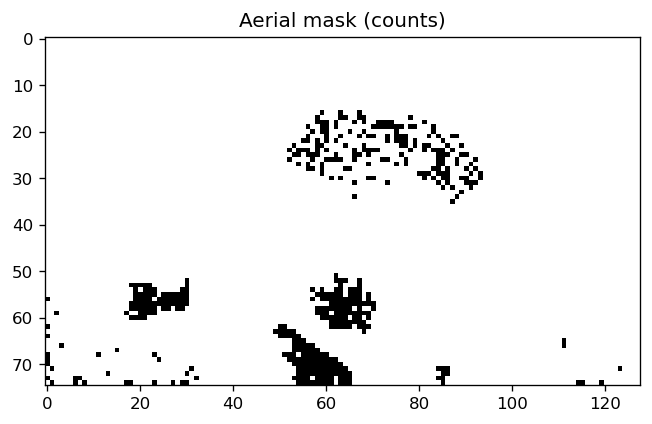

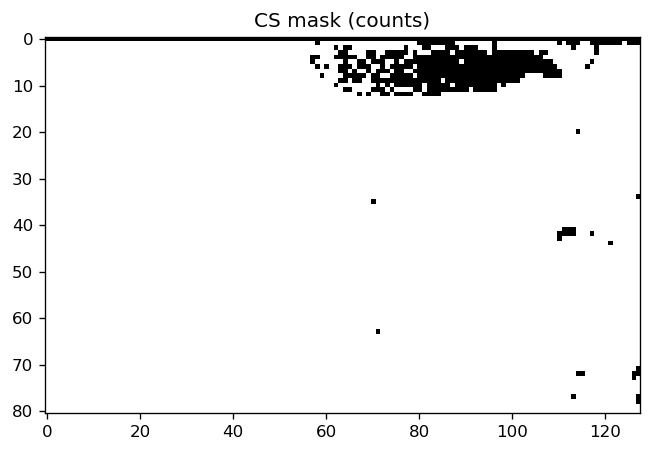

Aerial kept pixels: 0.9497916666666667
CS kept pixels    : 0.9494598765432098


In [26]:
# Make background mask (counts-based)
import numpy as np
import matplotlib.pyplot as plt

def total_counts_map(s_rb):
    # returns a 2D array
    tc = s_rb.sum(axis=s_rb.axes_manager.signal_indices_in_array)
    return np.asarray(tc.data)

tcA = total_counts_map(resA["s_rb"])
tcC = total_counts_map(resC["s_rb"])

# threshold at low quantile
q = 0.05 # tune here, 0.02-0.10
maskA = tcA > np.quantile(tcA, q)
maskC = tcC > np.quantile(tcC, q)

plt.figure(); plt.imshow(maskA, cmap="gray"); plt.title("Aerial mask (counts)"); plt.show()
plt.figure(); plt.imshow(maskC, cmap="gray"); plt.title("CS mask (counts)"); plt.show()

print("Aerial kept pixels:", maskA.mean())
print("CS kept pixels    :", maskC.mean())

In [29]:
# Background-correct line intensities (based on what the authors did for Cl)
# Double check and refine this later!! Just starter windows, adjust by checking the summed spectra
BKG_WINDOWS = {
    "C_Ka":  np.array([[0.20, 0.24, 0.32, 0.36]]),
    "O_Ka":  np.array([[0.45, 0.49, 0.58, 0.62]]),
    "Cl_Ka": np.array([[2.52, 2.56, 2.85, 2.92]]),  # authors used this
    "S_Ka":  np.array([[2.15, 2.20, 2.45, 2.50]]),
    "Zn_Ka": np.array([[8.30, 8.45, 8.85, 9.00]]),
    "Cd_La": np.array([[2.85, 2.95, 3.25, 3.35]]),
}

print("Background windows ready.")

Background windows ready.


In [31]:
# Updated pipeline (for now - pre-optimization)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

def eds_cluster_pipeline_bkg(
    s,
    xray_lines=("C_Ka", "O_Ka", "Cl_Ka", "S_Ka", "Zn_Ka", "Cd_La"),
    bkg_windows=None,                # dict like BKG_WINDOWS above
    rebin_scale=(8, 8, 2),
    counts_mask_quantile=0.05,       # mask based on total counts
    transform="log1p",               # "none" or "log1p"
    n_pca=6,
    k=4,
    random_state=0,
    dtype=np.float32,
):
    s = s.as_lazy()

    # Trim for lazy rebin
    n0, n1 = s.axes_manager.navigation_shape
    ne = s.axes_manager.signal_shape[0]
    f0, f1, fe = rebin_scale
    s = s.inav[:n0 - (n0 % f0), :n1 - (n1 % f1)].isig[:ne - (ne % fe)]

    # Rebin
    s_rb = s.rebin(scale=rebin_scale)

    # Build counts mask (2D) -> flatten
    tc = np.asarray(s_rb.sum(axis=s_rb.axes_manager.signal_indices_in_array).data)
    mask2d = tc > np.quantile(tc, counts_mask_quantile)
    keep = mask2d.ravel()

    # Line intensities (background corrected if provided)
    if bkg_windows is None:
        maps = s_rb.get_lines_intensity(xray_lines=list(xray_lines), plot_result=False)
    else:
        maps = []
        for line in xray_lines:
            bw = bkg_windows.get(line, None)
            if bw is None:
                m = s_rb.get_lines_intensity(xray_lines=[line], plot_result=False)[0]
            else:
                m = s_rb.get_lines_intensity(
                    xray_lines=[line],
                    background_windows=bw,
                    plot_result=False
                )[0]
            maps.append(m)

    # Feature matrix
    cols = [np.asarray(m.data, dtype=dtype).ravel() for m in maps]
    X = np.column_stack(cols)

    # Apply explicit mask
    Xk = X[keep]

    # Optional transform (variance stabilization)
    if transform == "log1p":
        Xk = np.log1p(np.maximum(Xk, 0))
    elif transform == "none":
        pass
    else:
        raise ValueError("transform must be 'none' or 'log1p'")

    # Scale + PCA
    scaler = StandardScaler()
    Z = scaler.fit_transform(Xk)

    pca = PCA(n_components=n_pca, random_state=random_state)
    P = pca.fit_transform(Z)

    # KMeans
    km = KMeans(n_clusters=k, random_state=random_state, n_init="auto")
    labels_keep = km.fit_predict(Z)
    sil = silhouette_score(Z, labels_keep) if k > 1 else np.nan

    # Label map (masked pixels = -1)
    nav_shape = maps[0].data.shape
    full = np.full(X.shape[0], -1, dtype=int)
    full[keep] = labels_keep
    label_map = full.reshape(nav_shape)

    return {
        "s_rb": s_rb,
        "maps": maps,
        "X": X,
        "keep": keep,
        "counts_mask_2d": mask2d,
        "scaler": scaler,
        "pca": pca,
        "kmeans": km,
        "labels_keep": labels_keep,
        "label_map": label_map,
        "silhouette": sil,
        "pca_scores": P,
    }

In [32]:
# Run pipeline for verification and quick comparison to earlier values
resA2 = eds_cluster_pipeline_bkg(sA, bkg_windows=BKG_WINDOWS, k=4, transform="log1p")
resC2 = eds_cluster_pipeline_bkg(sC, bkg_windows=BKG_WINDOWS, k=4, transform="log1p")

print("Aerial silhouette (bkg+mask+log1p):", resA2["silhouette"])
print("CS silhouette    (bkg+mask+log1p):", resC2["silhouette"])

Aerial silhouette (bkg+mask+log1p): 0.3618069291114807
CS silhouette    (bkg+mask+log1p): 0.2819347679615021


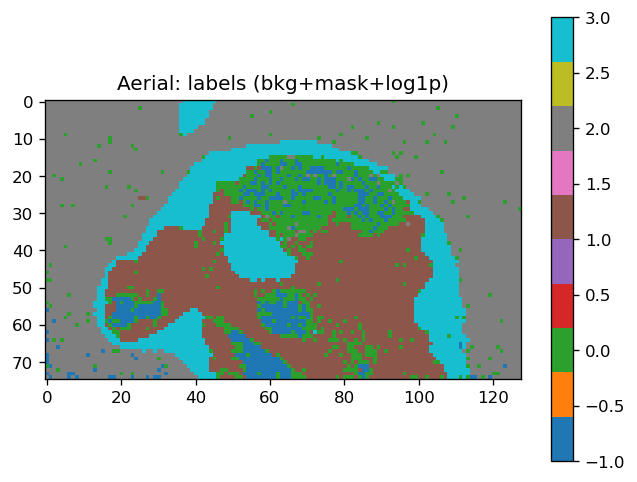

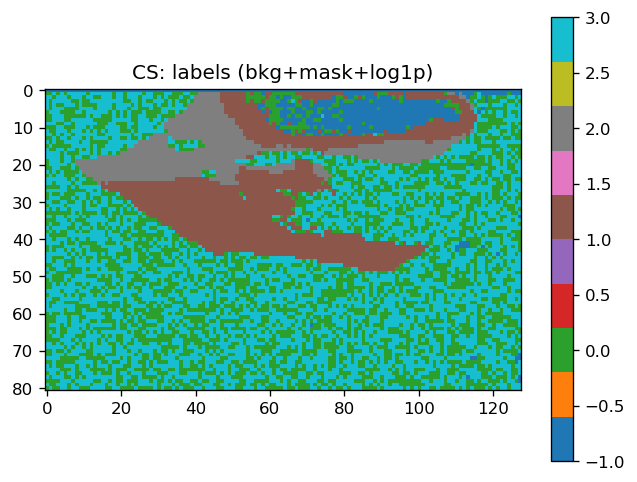

In [33]:
# Visual sanity check
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(resA2["label_map"], cmap="tab10")
plt.title("Aerial: labels (bkg+mask+log1p)")
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(resC2["label_map"], cmap="tab10")
plt.title("CS: labels (bkg+mask+log1p)")
plt.colorbar()
plt.show()

In [34]:
# I am confused

In [35]:
# Compare cluster mean compositions for validation of what changed after background correction
def cluster_means(X, labels):
    means = []
    for i in np.unique(labels):
        means.append(X[labels == i].mean(axis=0))
    return np.array(means)

meansA = cluster_means(resA2["X"][resA2["keep"]], resA2["labels_keep"])
meansC = cluster_means(resC2["X"][resC2["keep"]], resC2["labels_keep"])

print("Aerial cluster means:\n", meansA)
print("\nCS cluster means:\n", meansC)

Aerial cluster means:
 [[ 3.42961060e+02  6.34898453e+01  1.37487488e+01  1.33989363e+01
   2.53520317e+01 -2.03094780e-02]
 [ 2.06911942e+02  9.15520630e+01  3.53620005e+00  2.03511310e+00
   9.36083298e+01 -1.97607443e-01]
 [ 6.18831116e+02  7.32067871e+01  5.34370780e-01  9.65404570e-01
   5.52174866e-01  6.01307213e-01]
 [ 2.44780579e+02  8.73273392e+01 -1.17971063e+00  9.63411865e+01
   1.35928059e+01  1.08027336e+02]]

CS cluster means:
 [[ 6.5203644e+02  6.7884109e+01  5.8541951e+00  1.2586408e+00
   1.3369155e+00  8.1731051e-01]
 [ 2.6791071e+02  8.3314346e+01  4.2001343e+00  2.5980227e+00
   8.7354561e+01  4.7587130e-02]
 [ 2.7761224e+02  9.0840477e+01 -2.6103401e-01  1.0524212e+02
   8.9445143e+00  1.1502901e+02]
 [ 6.6456885e+02  6.9161804e+01 -2.7561157e+00  3.9176384e-01
   9.7424686e-01 -1.0136055e+00]]


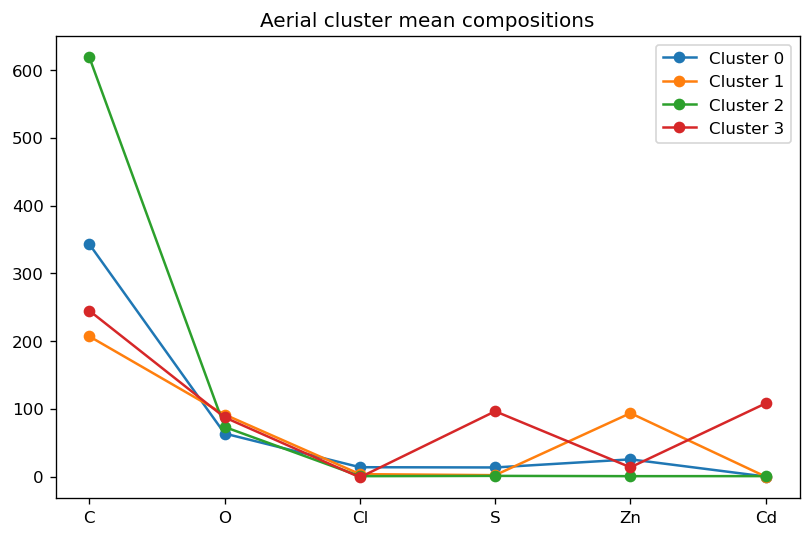

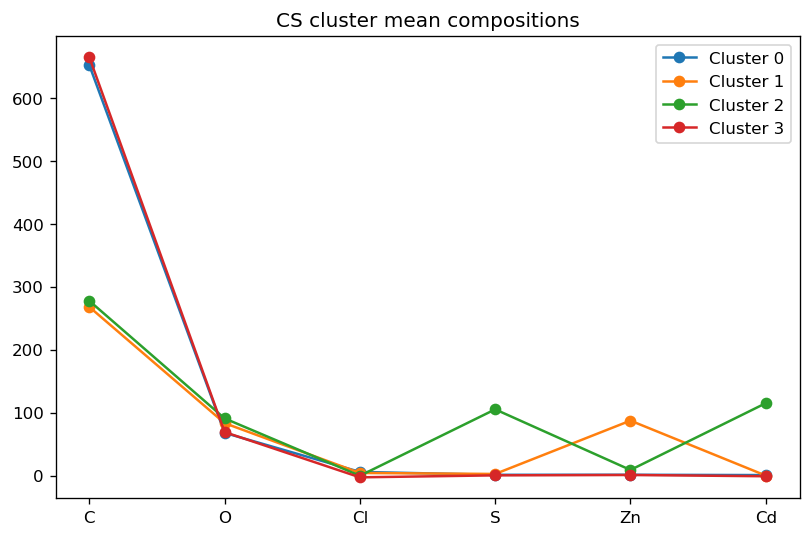

In [38]:
# Wait, potentially interesting -- plot it for better visualization
import matplotlib.pyplot as plt

elements = ["C", "O", "Cl", "S", "Zn", "Cd"]

plt.figure(figsize=(8,5))
for i, row in enumerate(meansA):
    plt.plot(elements, row, marker="o", label=f"Cluster {i}")
plt.legend()
plt.title("Aerial cluster mean compositions")
plt.show()

plt.figure(figsize=(8,5))
for i, row in enumerate(meansC):
    plt.plot(elements, row, marker="o", label=f"Cluster {i}")
plt.legend()
plt.title("CS cluster mean compositions")
plt.show()